# Clustering Crypto

In [35]:
import requests
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


### Data Preprocessing

In [36]:
# load data from resources
file_path = Path("Resources/crypto_data.csv")
crypto_df = pd.read_csv(file_path, index_col=0)
crypto_df.head(10)

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
1337,EliteCoin,X13,True,PoW/PoS,2.927942e+10,314159265359
2015,2015 coin,X11,True,PoW/PoS,NaN,0
BTC,Bitcoin,SHA-256,True,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,True,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,True,PoW,6.303924e+07,84000000


In [37]:
crypto_df.shape

(1252, 6)

In [38]:
# Check if XMR is listed properly
crypto_df[crypto_df["CoinName"] == "Monero"]

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
XMR,Monero,CryptoNight-V7,True,PoW,1.720114e+07,0


In [39]:
# Keep only cryptocurrencies that are on trading
crypto_df = crypto_df[crypto_df["IsTrading"] == True]
crypto_df.shape

(1144, 6)

In [40]:
# Keep only cryptocurrencies with a working algorithm
crypto_df = crypto_df[crypto_df["Algorithm"] != "N/A"]
crypto_df.shape

(1144, 6)

In [41]:
# Remove the "IsTrading" column
crypto_df.drop("IsTrading", axis=1, inplace=True)
crypto_df.head()

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
365,365Coin,X11,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,PoW,NaN,611000
808,808,SHA-256,PoW/PoS,0.000000e+00,0


In [42]:
# Removing rows with at least 1 null valuec
crypto_df = crypto_df.dropna(axis=0, how="any")
crypto_df.shape

(685, 5)

In [43]:
# Removing rows with cryptocurrencies without coins, mined
crypto_df = crypto_df[crypto_df["TotalCoinsMined"] > 0]
crypto_df.shape

(532, 5)

In [44]:
crypto_df.head(10)

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethereum,Ethash,PoW,1.076842e+08,0
LTC,Litecoin,Scrypt,PoW,6.303924e+07,84000000
DASH,Dash,X11,PoW/PoS,9.031294e+06,22000000
XMR,Monero,CryptoNight-V7,PoW,1.720114e+07,0
ETC,Ethereum Classic,Ethash,PoW,1.133597e+08,210000000
ZEC,ZCash,Equihash,PoW,7.383056e+06,21000000


In [45]:
# Dropping rows where there are 'N/A' text values


In [46]:
# Fetching the cryptocurrencies names prior to drop them from crypto_df
coins_name = pd.DataFrame(crypto_df["CoinName"], index=crypto_df.index)
coins_name.head()
coins_name.shape


(532, 1)

In [47]:
# Removig the cryptocurrency name since it's not going to be used on the clustering algorithm
crypto_df = crypto_df.drop("CoinName", axis=1)
crypto_df.head(10)


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0
LTC,Scrypt,PoW,6.303924e+07,84000000
DASH,X11,PoW/PoS,9.031294e+06,22000000
XMR,CryptoNight-V7,PoW,1.720114e+07,0
ETC,Ethash,PoW,1.133597e+08,210000000
ZEC,Equihash,PoW,7.383056e+06,21000000


In [48]:
# Creating dummies variables for text features
X = pd.get_dummies(data=crypto_df, columns=["Algorithm", "ProofType"])
X.shape


(532, 98)

In [49]:
X.head(10)

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LTC,6.303924e+07,84000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DASH,9.031294e+06,22000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
XMR,1.720114e+07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETC,1.133597e+08,210000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZEC,7.383056e+06,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Standardizing data
X = StandardScaler().fit_transform(X)
X

array([[-0.11710817, -0.1528703 , -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.09396955, -0.145009  , -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [ 0.52494561,  4.48942416, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       ...,
       [-0.09561336, -0.13217937, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.11694817, -0.15255998, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ],
       [-0.11710536, -0.15285552, -0.0433963 , ..., -0.0433963 ,
        -0.0433963 , -0.0433963 ]])

### Reducing Dimensions Using PCA

In [51]:
# Using PCA to reduce dimension to 3 principal components
n_comp = 3
pca = PCA(n_components=n_comp)
principal_components = pca.fit_transform(X)
principal_components


array([[-0.33171101,  1.0023005 , -0.5472863 ],
       [-0.3150546 ,  1.0023476 , -0.54761038],
       [ 2.28776367,  1.58202915, -0.45892565],
       ...,
       [ 0.32253891, -2.26181255,  0.45905418],
       [-0.14755759, -2.00058783,  0.45050498],
       [-0.28714963,  0.80025403, -0.26706095]])

In [52]:
# Creating a DataFrame with the principal components data
col_names = [f"PC {i}" for i in range(1, n_comp +1)]
pcs_df = pd.DataFrame(principal_components, columns=col_names, index=crypto_df.index)

pcs_df.head(10)
pcs_df.shape

(532, 3)

### Clustering Crytocurrencies Using K-Means

#### Finding the Best Value for `k` Using the Elbow Curve

In [53]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range ok k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(pcs_df)
    inertia.append(km.inertia_)
    

In [54]:
# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}

df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x='k', y = "inertia", xticks=k, title = "Elbow Curve")

:Curve   [k]   (inertia)

Running K-Means with `k=<you best value for k here>`

In [55]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

In [56]:
# Fit the model
model.fit(pcs_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [57]:
# Predict clusters
predictions = model.predict(pcs_df)

In [58]:
# Creating a new DataFrame including predicted clusters and cryptocurrencies features
clustered_df = pd.concat([crypto_df, pcs_df], axis=1, sort=False)
clustered_df['CoinName'] = coins_name['CoinName']
clustered_df['Class'] = model.labels_
clustered_df.shape

(532, 9)

### Visualizing Results

#### 3D-Scatter with Clusters

In [59]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x ="PC 1",
    y = "PC 2",
    z = 'PC 3',
    color = 'Class',
    hover_name ='CoinName',
    hover_data = ['Algorithm'],
    width = 800,
)

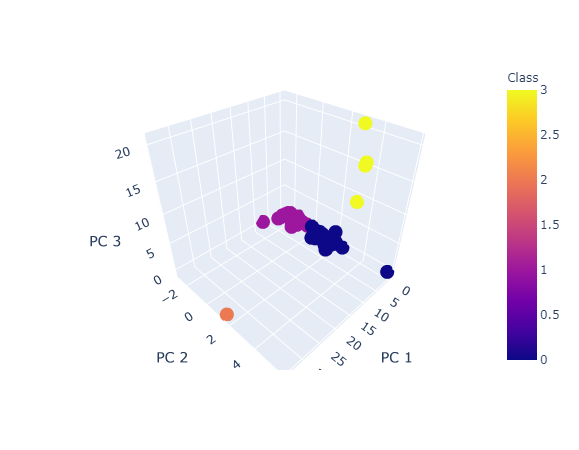

In [60]:
fig.update_layout(legend = dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [68]:
# Table with tradable cryptos
clustered_df[
    [
        'CoinName',
         'Algorithm',
         'ProofType',
         'TotalCoinSupply',
         'TotalCoinsMined',
         'Class',     
        
    ]  
].hvplot.table()


:Table   [CoinName,Algorithm,ProofType,TotalCoinSupply,TotalCoinsMined,Class]

#### Scatter Plot with Tradable Cryptocurrencies

In [62]:
# Print the total number of tradable cryptocurrencies
print(f"There are {clustered_df.shape[0]} tradable cryptocurrencies.")

There are 532 tradable cryptocurrencies.


In [69]:
# Scaling data to create the scatter plot
mm_scaler = MinMaxScaler()
plot_data = mm_scaler.fit_transform(
    clustered_df[["TotalCoinSupply", "TotalCoinsMined"]]
    )

In [70]:
plot_df = pd.DataFrame(
    plot_data, columns=["TotalCoinSupply", "TotalCoinsMined"], index=clustered_df.index
)

In [71]:
plot_df['CoinName'] = clustered_df['CoinName']
plot_df['Class'] = clustered_df['Class']
plot_df.head()

,TotalCoinSupply,TotalCoinsMined,CoinName,Class
42,4.200000e-11,0.000000,42 Coin,0
404,5.320000e-04,0.001066,404Coin,0
1337,3.141593e-01,0.029576,EliteCoin,0
BTC,2.100000e-05,0.000018,Bitcoin,1
ETH,0.000000e+00,0.000109,Ethereum,1


In [72]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
plot_df.hvplot.scatter(
    x="TotalCoinsMined", y="TotalCoinSupply", hover_cols=["CoinName"], by="Class"
)


:NdOverlay   [Class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)